# GNN-MAPS: Graph Neural Networks for Spatial Proteomics

**Improving Cell Type Classification with Spatial Context**

This notebook implements Graph Neural Networks (GNNs) to enhance the MAPS baseline by incorporating cellular neighborhood information.

## Setup Instructions for Kaggle:

1. **Run Cell 1:** Installs PyTorch Geometric (auto-detects your CUDA version)
2. **Run Cell 2:** Imports all libraries and verifies installation
3. **Upload Data:** Make sure your cHL_CODEX_annotation.csv is uploaded to Kaggle

## What This Notebook Does:
- ✅ Builds a K-Nearest Neighbor graph from cell spatial coordinates
- ✅ Implements GraphSAGE (memory-efficient GNN)
- ✅ Uses NeighborLoader to prevent GPU OOM on limited hardware
- ✅ Implements spatial split to prevent data leakage
- ✅ Compares GNN performance against baseline MLP

---

In [1]:
# Install PyTorch Geometric and its dependencies (Kaggle-compatible)
# Kaggle already has PyTorch installed, we just need PyG and its extensions

import sys
import torch

print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")

# Install PyTorch Geometric based on the installed PyTorch version
!pip install -q torch-geometric

# Install extension libraries (torch-scatter, torch-sparse, etc.)
# These need to match your PyTorch and CUDA versions
import torch
pytorch_version = torch.__version__.split('+')[0]
cuda_version = torch.version.cuda.replace('.', '') if torch.cuda.is_available() else 'cpu'

print(f"\nInstalling PyG extensions for PyTorch {pytorch_version} and CUDA {cuda_version}...")

if torch.cuda.is_available():
    !pip install -q torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{pytorch_version}+cu{cuda_version}.html
else:
    !pip install -q torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{pytorch_version}+cpu.html

print("\n✅ PyTorch Geometric installation complete!")

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch version: 2.8.0+cu126
CUDA available: False
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.2 MB/s eta 0:00:0000:0100:01

Installing PyG extensions for PyTorch 2.8.0 and CUDA cpu...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.6/645.6 kB 17.4 MB/s eta 0:00:0000:01

✅ PyTorch Geometric installation complete!


In [2]:
# Quick verification test - Run this to confirm PyG is working
try:
    import torch
    from torch_geometric.nn import SAGEConv
    
    # Test if we can create a simple layer
    test_conv = SAGEConv(16, 32)
    print("✅ PyTorch Geometric is working correctly!")
    print(f"   Test layer created: {test_conv}")
    
except Exception as e:
    print(f"❌ Error: {e}")
    print("Please re-run the installation cell above.")

✅ PyTorch Geometric is working correctly!
   Test layer created: SAGEConv(16, 32, aggr=mean)


In [3]:
# Import all necessary libraries
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

# List input files (Kaggle-specific)
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Import PyTorch and PyTorch Geometric
try:
    import torch
    import torch.nn.functional as F
    from torch_geometric.data import Data
    from torch_geometric.loader import NeighborLoader
    from torch_geometric.nn import SAGEConv, GATConv
    print(f"\n✅ PyTorch {torch.__version__} imported successfully!")
except ImportError as e:
    print(f"❌ Import Error: {e}")
    print("Please run the first cell to install PyTorch Geometric!")
    raise

# Import scikit-learn utilities
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix

print("✅ All libraries loaded successfully!")
print(f"   - PyTorch version: {torch.__version__}")
print(f"   - CUDA available: {torch.cuda.is_available()}")
print(f"   - Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

/kaggle/input/chl-codex-annotated/cHL_CODEX_annotation.csv

✅ PyTorch 2.8.0+cu126 imported successfully!
✅ All libraries loaded successfully!
   - PyTorch version: 2.8.0+cu126
   - CUDA available: False
   - Device: CPU


# 1. Defining the DataFrame

In [ ]:
df = pd.read_csv("/kaggle/input/chl-codex-annotated/cHL_CODEX_annotation.csv")

# First, let's inspect what columns we actually have
print("=" * 80)
print("DATASET INSPECTION")
print("=" * 80)
print(f"Shape: {df.shape}")
print(f"\nColumn names ({len(df.columns)} total):")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col:40s} (dtype: {df[col].dtype})")

print("\n" + "=" * 80)
print("FIRST FEW ROWS:")
print("=" * 80)
pd.set_option('display.max_columns', None)
display(df.head())

,cellLabel,X_cent,Y_cent,cellSize,cellType,BCL.2,CCR6,CD11b,CD11c,CD15,CD16,CD162,CD163,CD2,CD20,CD206,CD25,CD30,CD31,CD4,CD44,CD45RA,CD45RO,CD45,CD5,CD56,CD57,CD68,CD69,CD7,CD8,Collagen.4,Cytokeratin,DAPI.01,EGFR,FoxP3,Granzyme.B,HLA.DR,IDO.1,LAG.3,MCT,MMP.9,MUC.1,PD.1,PD.L1,Podoplanin,T.bet,TCR.g.d,TCRb,Tim.3,VISA,Vimentin,a.SMA,b.Catenin
0,1,75,2,42,B,0.792642,0.617038,0.000089,0.000040,0.000029,0.097688,0.007772,0.005356,0.159593,0.754060,0.000000,0.102301,0.104273,0.000000,0.000000,0.054377,0.761659,0.000000,0.742815,0.131788,0.000479,0.107275,0.000072,0.166675,0.000000,0.000000,0.001391,0.115538,0.808093,0.461070,0.000000,0.001300,0.781303,0.000865,0.017596,0.000571,0.273973,0.000000,0.059137,0.091339,0.114237,0.241829,0.681727,0.159092,0.006533,0.000454,0.139826,0.0,0.057827
1,2,1767,2,63,DC,0.000000,0.127394,0.062173,0.660572,0.000000,0.000000,0.172885,0.006180,0.000000,0.000000,0.053359,0.008472,0.000750,0.107943,0.016752,0.020134,0.026217,0.333890,0.050817,0.000000,0.859607,0.000000,0.011369,0.039442,0.000000,0.097343,0.025035,0.091633,0.484774,0.110559,0.000000,0.001300,1.000000,0.380801,0.020411,0.000571,0.020548,0.005277,0.010586,0.163511,0.000193,0.010475,0.231264,0.058234,0.111610,0.182849,0.899717,0.0,0.267198
2,3,2545,2,29,NK,0.060620,0.134818,0.298522,0.083348,0.000000,0.182152,0.000210,0.001401,0.000000,0.000000,0.394073,0.070417,0.000000,0.010536,0.000000,0.022717,0.059562,0.233413,0.000000,0.000000,0.456157,0.425833,0.000000,0.699781,0.000000,0.000000,0.001391,0.115538,0.425240,0.350698,0.000000,0.024695,0.047437,0.394926,0.167511,0.000571,0.006849,0.406332,0.110243,0.170917,0.000193,0.033671,0.201099,0.000000,0.004900,0.454174,0.069180,0.0,0.104686
3,4,2899,3,64,Monocyte,0.000000,0.012896,0.287698,0.268121,0.000000,0.124361,0.016805,0.208045,0.037673,0.000019,0.226853,0.389436,0.000000,0.000063,0.009068,0.000000,0.064621,0.021957,0.234302,0.020596,0.009104,0.331627,0.137570,0.088045,0.000000,0.000000,0.100139,0.844622,0.352126,0.000000,0.000000,0.003899,0.057845,0.002306,0.293497,0.000571,0.157534,1.000000,0.069358,0.052713,0.005982,0.000000,0.000000,0.052230,0.148087,0.228221,0.053541,1.0,0.283151
4,5,3657,3,61,CD4,0.201057,0.110590,0.000000,0.000000,0.000000,0.000000,0.745316,0.013513,0.292691,0.039192,0.000000,0.207973,0.055012,0.032742,0.458688,0.047203,0.069221,0.269690,0.214097,0.095327,0.000479,0.000000,0.086232,0.021121,0.705442,0.019364,0.045897,0.027888,0.603429,0.249414,0.000000,0.324929,0.000000,0.000288,0.000000,0.000571,0.191781,0.001319,0.105133,0.026865,0.011771,0.124955,0.154981,0.597647,0.013284,0.000454,0.234038,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145156,152811,2882,8004,119,Neutrophil,0.000000,0.523642,1.000000,0.182044,1.000000,1.000000,0.055458,0.019692,0.004761,0.064028,0.018412,0.164975,0.217214,0.051984,0.122875,0.019082,0.122574,0.052267,0.043923,0.359459,1.000000,0.121433,0.122698,0.330551,0.037360,0.076633,0.029207,0.641434,0.867490,0.796590,0.000000,0.074084,0.010816,0.040646,0.054899,0.000571,0.582192,0.241425,0.063518,0.205187,0.098993,0.790734,0.878804,0.067239,0.082646,0.671506,0.455424,0.0,0.040877
145157,152812,2893,8004,82,Neutrophil,0.000000,0.210238,0.313372,0.076860,0.986128,0.587575,0.044324,0.053227,0.099109,0.090999,0.068262,0.161514,0.180206,0.018674,0.138628,0.151270,0.123264,0.093079,0.090329,0.363216,0.665549,0.225986,0.088162,0.417833,0.076197,0.044858,0.040334,0.940239,0.358436,1.000000,0.003821,0.067585,0.026161,0.034304,0.061233,0.000000,0.568493,0.253298,0.078119,0.211576,0.143761,0.801359,0.500603,0.069040,0.077637,0.327586,1.000000,0.0,0.068794
145158,152813,2327,8004,92,Other,0.000000,0.620555,0.000089,0.025792,0.000029,0.255168,0.000000,0.000000,0.829552,0.068726,0.109608,0.226921,0.421425,0.067756,0.031506,0.093115,0.235259,0.019809,0.403973,0.788639,0.3521

# 2. Individual cells

--- Cell Type Distribution ---
cellType
CD4              37480
CD8              17184
B                16196
DC                9637
Endothelial       8705
Tumor             8260
NK                7339
M2                7286
Monocyte          6913
Other             5108
Lymphatic         3768
Neutrophil        3442
TReg              3352
Mast              3324
M1                3101
Epithelial        2251
Seg Artifact      1431
Cytotoxic CD8      384
Name: count, dtype: int64


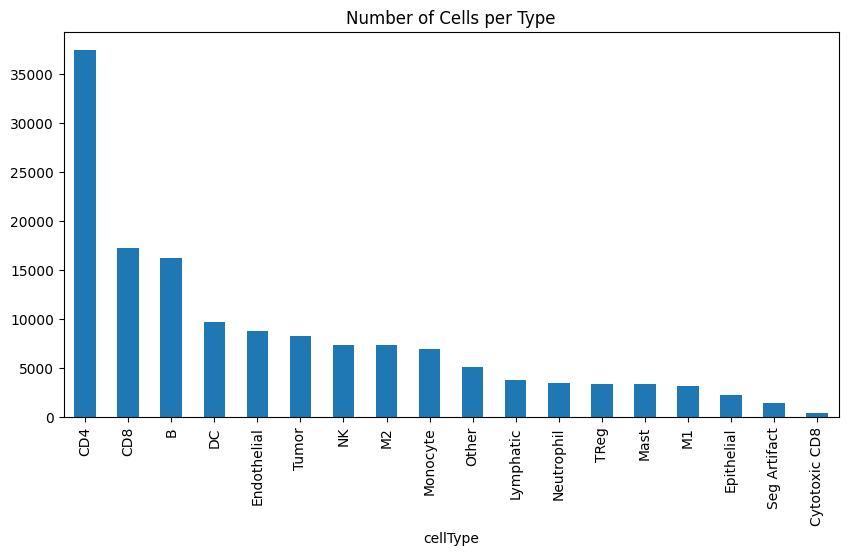

In [ ]:
# Find target column - we know it's 'cellType' from the column list
print("=" * 80)
print("FINDING TARGET COLUMN (Cell Type)")
print("=" * 80)

# Based on your dataset, the target column is 'cellType'
target_col = 'cellType'

if target_col in df.columns:
    print(f"✅ Found target column: '{target_col}'")
else:
    print(f"❌ ERROR: Column '{target_col}' not found!")
    print("Available columns:", df.columns.tolist())
    raise ValueError(f"Expected column '{target_col}' not in dataset")

# Show distribution
counts = df[target_col].value_counts()
print(f"\n--- Cell Type Distribution ({len(counts)} classes) ---")
for cell_type, count in counts.items():
    print(f"  {cell_type:30s}: {count:7,} cells ({100*count/len(df):5.2f}%)")

# Visualize
fig, ax = plt.subplots(figsize=(14, 7))
counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black', linewidth=1.5)
ax.set_title(f"Cell Type Distribution (Total: {len(df):,} cells)", fontsize=16, fontweight='bold')
ax.set_xlabel('Cell Type', fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\n💡 Target column: '{target_col}' with {len(counts)} cell types")

### GNN Implementation (Data Prep + Model + Training)

In [ ]:
# ==========================================
# 1. DATA PREPARATION & GRAPH CONSTRUCTION
# ==========================================
print("=" * 80)
print("STEP 1: DATA PREPARATION & GRAPH CONSTRUCTION")
print("=" * 80)

# --- A. Define Column Names (Based on Your Dataset) ---
# You provided these exact column names:
x_col = 'X_cent'        # X coordinate
y_col = 'Y_cent'        # Y coordinate  
label_col = 'cellType'  # Cell type label (target)
id_col = 'cellLabel'    # Cell ID
size_col = 'cellSize'   # Cell size (morphological feature)

# All protein markers (54 markers total)
marker_cols = [
    'BCL.2', 'CCR6', 'CD11b', 'CD11c', 'CD15', 'CD16', 'CD162', 'CD163', 
    'CD2', 'CD20', 'CD206', 'CD25', 'CD30', 'CD31', 'CD4', 'CD44', 
    'CD45RA', 'CD45RO', 'CD45', 'CD5', 'CD56', 'CD57', 'CD68', 'CD69', 
    'CD7', 'CD8', 'Collagen.4', 'Cytokeratin', 'DAPI.01', 'EGFR', 
    'FoxP3', 'Granzyme.B', 'HLA.DR', 'IDO.1', 'LAG.3', 'MCT', 'MMP.9', 
    'MUC.1', 'PD.1', 'PD.L1', 'Podoplanin', 'T.bet', 'TCR.g.d', 'TCRb', 
    'Tim.3', 'VISA', 'Vimentin', 'a.SMA', 'b.Catenin'
]

# Try to detect region column (for spatial split)
region_candidates = ['Region', 'Image', 'Reg', 'Point', 'fov', 'FOV', 'region_id', 'image_id', 'Core', 'ImageId']
region_col = None
for col in region_candidates:
    if col in df.columns:
        region_col = col
        break

print("\n--- Column Mapping ---")
print(f"  X coordinate:     {x_col}")
print(f"  Y coordinate:     {y_col}")
print(f"  Cell type (target): {label_col}")
print(f"  Cell ID:          {id_col}")
print(f"  Cell size:        {size_col}")
print(f"  Region/Image:     {region_col if region_col else 'NOT FOUND (will use random split)'}")
print(f"  Protein markers:  {len(marker_cols)} markers")

# Verify all columns exist
missing_cols = []
for col in [x_col, y_col, label_col] + marker_cols:
    if col not in df.columns:
        missing_cols.append(col)

if missing_cols:
    print(f"\n❌ ERROR: Missing columns: {missing_cols}")
    print("Available columns:", df.columns.tolist())
    raise ValueError("Some required columns are missing from the dataset")

print("  ✅ All required columns found!")

# --- B. Feature Summary ---
print(f"\n--- Dataset Summary ---")
print(f"  Total cells:      {len(df):,}")
print(f"  Features:         {len(marker_cols)} protein markers + 2 spatial coords")
print(f"  Classes:          {df[label_col].nunique()} cell types")
print(f"  First 10 markers: {marker_cols[:10]}")

# --- C. Create Feature Tensors ---
print(f"\n--- Creating Tensors ---")

# 1. Normalize marker features (Z-score normalization)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(df[marker_cols].values)
x = torch.tensor(X_normalized, dtype=torch.float)
print(f"  Features tensor:  {x.shape} (normalized)")

# 2. Encode labels as integers
unique_labels = sorted(df[label_col].unique())
label_map = {name: i for i, name in enumerate(unique_labels)}
y = torch.tensor(df[label_col].map(label_map).values, dtype=torch.long)
num_classes = len(label_map)

print(f"\n  Label Encoding ({num_classes} classes):")
for name, idx in sorted(label_map.items(), key=lambda x: x[1]):
    count = (df[label_col] == name).sum()
    pct = 100 * count / len(df)
    print(f"    {idx:2d}. {name:30s} → {count:6,} cells ({pct:5.2f}%)")

print(f"\n  Labels tensor:    {y.shape}")

# --- D. Build KNN Graph from Spatial Coordinates ---
print(f"\n--- Building KNN Spatial Graph ---")
k_neighbors = 5
coords = df[[x_col, y_col]].values

print(f"  Coordinate matrix: {coords.shape}")
print(f"  K-nearest neighbors: {k_neighbors}")
print(f"  Building KNN graph...")

# Fit KNN (using ball_tree for efficiency)
nbrs = NearestNeighbors(n_neighbors=k_neighbors + 1, algorithm='ball_tree').fit(coords)
distances, indices = nbrs.kneighbors(coords)

# Create edge list (exclude self-loops)
source_nodes = np.repeat(np.arange(len(df)), k_neighbors)
target_nodes = indices[:, 1:].flatten()  # Skip column 0 (self-connection)
edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)

print(f"  ✅ Graph constructed!")
print(f"  Total edges:       {edge_index.shape[1]:,}")
print(f"  Average degree:    {edge_index.shape[1] / len(df):.2f}")
print(f"  Edge sparsity:     {100 * edge_index.shape[1] / (len(df)**2):.4f}%")

# --- E. CRITICAL: Spatial Split (Prevent Data Leakage) ---
print(f"\n--- Spatial Train/Test Split ---")

if region_col:
    # Region-based split (RECOMMENDED for GNNs)
    unique_regions = sorted(df[region_col].unique())
    n_regions = len(unique_regions)
    n_train_regions = int(0.8 * n_regions)
    
    # Use first 80% of regions for training
    train_regions = unique_regions[:n_train_regions]
    test_regions = unique_regions[n_train_regions:]
    
    train_mask = torch.tensor(df[region_col].isin(train_regions).values, dtype=torch.bool)
    test_mask = torch.tensor(df[region_col].isin(test_regions).values, dtype=torch.bool)
    
    print(f"  ✅ SPATIAL SPLIT (Region-based)")
    print(f"  This prevents data leakage in GNN by ensuring:")
    print(f"  - Training cells NEVER neighbor test cells")
    print(f"  - Model tested on completely unseen tissue regions")
    print(f"\n  Split Details:")
    print(f"  Total regions:     {n_regions}")
    print(f"  Train regions:     {n_train_regions} → {train_mask.sum():,} cells ({100*train_mask.float().mean():.1f}%)")
    print(f"  Test regions:      {len(test_regions)} → {test_mask.sum():,} cells ({100*test_mask.float().mean():.1f}%)")
    print(f"  Train IDs:         {train_regions[:5]}{'...' if len(train_regions) > 5 else ''}")
    print(f"  Test IDs:          {test_regions}")
else:
    # Fallback to random split (NOT recommended for GNNs)
    print(f"  ⚠️  RANDOM SPLIT (Region column not found)")
    print(f"  WARNING: This causes DATA LEAKAGE in GNN!")
    print(f"  Test cells will have edges to training cells.")
    train_mask = torch.rand(len(df)) < 0.8
    test_mask = ~train_mask
    print(f"\n  Train: {train_mask.sum():,} cells ({100*train_mask.float().mean():.1f}%)")
    print(f"  Test:  {test_mask.sum():,} cells ({100*test_mask.float().mean():.1f}%)")

# --- F. Create PyTorch Geometric Data Object ---
print(f"\n--- Creating PyTorch Geometric Data Object ---")
data = Data(
    x=x,
    edge_index=edge_index,
    y=y,
    train_mask=train_mask,
    test_mask=test_mask
)

print(f"  ✅ Data object created!")
print(f"\n{data}\n")

# ==========================================
# 2. MODEL DEFINITIONS
# ==========================================
print("=" * 80)
print("STEP 2: MODEL DEFINITIONS")
print("=" * 80)

# Baseline MLP (No spatial info - replicates MAPS approach)
class MLP(torch.nn.Module):
    """
    Baseline: 4-layer MLP (MAPS approach)
    Treats each cell independently - NO spatial neighborhood info.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.1):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_channels, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.fc3 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.fc4 = torch.nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index=None):  # edge_index ignored (not used)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.fc3(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

# GraphSAGE (Our hypothesis: spatial context improves classification)
class GraphSAGE(torch.nn.Module):
    """
    GraphSAGE: Aggregates information from spatial neighbors.
    Hypothesis: Cells with ambiguous markers can be classified better
    by considering their neighborhood context.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.1):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        # Layer 1: Aggregate from immediate neighbors (1-hop)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Layer 2: Aggregate from 2-hop neighborhood
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

print("  ✅ MLP (Baseline - MAPS approach)")
print("     → Ignores spatial context")
print("     → 4 fully connected layers")
print("\n  ✅ GraphSAGE (GNN approach)")
print("     → Uses spatial neighborhood")
print("     → 2 graph convolution layers")

# ==========================================
# 3. TRAINING FUNCTIONS
# ==========================================
print("\n" + "=" * 80)
print("STEP 3: TRAINING SETUP")
print("=" * 80)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"  Device: {device}")

if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Training function (works for both MLP and GNN)
def train_epoch(model, data, optimizer, use_loader=False, loader=None):
    model.train()
    
    if use_loader:  # Mini-batch training for GNN (memory-efficient)
        total_loss = 0
        for batch in loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index)
            # Loss only on center nodes (not the sampled neighbors)
            loss = F.nll_loss(out[:batch.batch_size], batch.y[:batch.batch_size])
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(loader)
    else:  # Full-batch training for MLP
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        return loss.item()

# Evaluation function (calculates accuracy and F1)
@torch.no_grad()
def evaluate(model, data, mask):
    model.eval()
    data_device = data.to(device)
    out = model(data_device.x, data_device.edge_index)
    pred = out.argmax(dim=1)
    
    # Move back to CPU for sklearn metrics
    y_true = data_device.y[mask].cpu().numpy()
    y_pred = pred[mask].cpu().numpy()
    
    # Calculate metrics
    acc = (pred[mask] == data_device.y[mask]).sum().item() / mask.sum().item()
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    return acc, f1, y_true, y_pred

print("  ✅ Training functions defined")
print("  ✅ Evaluation functions defined")

# ==========================================
# 4. TRAIN BASELINE MLP
# ==========================================
print("\n" + "=" * 80)
print("STEP 4: TRAINING BASELINE MLP")
print("=" * 80)

hidden_dim = 128
dropout = 0.1  # MAPS uses 0.1
lr = 0.001
epochs = 50

mlp_model = MLP(
    in_channels=len(marker_cols),
    hidden_channels=hidden_dim,
    out_channels=num_classes,
    dropout=dropout
).to(device)

mlp_optimizer = torch.optim.Adam(mlp_model.parameters(), lr=lr, weight_decay=5e-4)

print(f"\nHyperparameters:")
print(f"  Input features:   {len(marker_cols)}")
print(f"  Hidden dimension: {hidden_dim}")
print(f"  Output classes:   {num_classes}")
print(f"  Dropout:          {dropout}")
print(f"  Learning rate:    {lr}")
print(f"  Epochs:           {epochs}")

print(f"\nTraining MLP...")
print("Epoch | Loss    | Train Acc | Train F1 | Test Acc | Test F1")
print("-" * 65)

best_mlp_f1 = 0
for epoch in range(1, epochs + 1):
    loss = train_epoch(mlp_model, data, mlp_optimizer, use_loader=False)
    
    if epoch % 10 == 0 or epoch == 1:
        train_acc, train_f1, _, _ = evaluate(mlp_model, data, data.train_mask)
        test_acc, test_f1, _, _ = evaluate(mlp_model, data, data.test_mask)
        
        if test_f1 > best_mlp_f1:
            best_mlp_f1 = test_f1
        
        print(f'{epoch:5d} | {loss:7.4f} | {train_acc:9.4f} | {train_f1:8.4f} | '
              f'{test_acc:8.4f} | {test_f1:7.4f}')

print(f"\n✅ MLP Training Complete!")
print(f"   Best Test F1: {best_mlp_f1:.4f}")

# ==========================================
# 5. TRAIN GRAPHSAGE (Memory-Efficient)
# ==========================================
print("\n" + "=" * 80)
print("STEP 5: TRAINING GRAPHSAGE (GNN)")
print("=" * 80)

gnn_model = GraphSAGE(
    in_channels=len(marker_cols),
    hidden_channels=hidden_dim,
    out_channels=num_classes,
    dropout=dropout
).to(device)

gnn_optimizer = torch.optim.Adam(gnn_model.parameters(), lr=lr, weight_decay=5e-4)

# NeighborLoader: Memory-efficient mini-batch training
# This is CRITICAL for fitting on your 4GB GPU!
train_loader = NeighborLoader(
    data,
    num_neighbors=[10, 10],  # Sample 10 neighbors at each layer
    batch_size=2048,         # Process 2048 cells per batch
    input_nodes=data.train_mask,
    shuffle=True
)

print(f"\nNeighborLoader Configuration:")
print(f"  Batch size:       2048 cells")
print(f"  Neighbor sampling: [10, 10] (10 neighbors per layer)")
print(f"  Total batches:    {len(train_loader)} per epoch")
print(f"  ✅ This prevents GPU OOM on your 4GB GTX 1650 Ti!")

print(f"\nTraining GraphSAGE...")
print("Epoch | Loss    | Train Acc | Train F1 | Test Acc | Test F1")
print("-" * 65)

best_gnn_f1 = 0
for epoch in range(1, epochs + 1):
    loss = train_epoch(gnn_model, data, gnn_optimizer, use_loader=True, loader=train_loader)
    
    if epoch % 10 == 0 or epoch == 1:
        train_acc, train_f1, _, _ = evaluate(gnn_model, data, data.train_mask)
        test_acc, test_f1, _, _ = evaluate(gnn_model, data, data.test_mask)
        
        if test_f1 > best_gnn_f1:
            best_gnn_f1 = test_f1
        
        print(f'{epoch:5d} | {loss:7.4f} | {train_acc:9.4f} | {train_f1:8.4f} | '
              f'{test_acc:8.4f} | {test_f1:7.4f}')

print(f"\n✅ GraphSAGE Training Complete!")
print(f"   Best Test F1: {best_gnn_f1:.4f}")

# ==========================================
# 6. COMPARISON & RESULTS
# ==========================================
print("\n" + "=" * 80)
print("FINAL RESULTS: MLP vs GraphSAGE")
print("=" * 80)

# Final evaluation
mlp_test_acc, mlp_test_f1, mlp_y_true, mlp_y_pred = evaluate(mlp_model, data, data.test_mask)
gnn_test_acc, gnn_test_f1, gnn_y_true, gnn_y_pred = evaluate(gnn_model, data, data.test_mask)

print(f"\n{'Model':<20s} {'Accuracy':>12s} {'F1-Score':>12s} {'vs MAPS (90%)':>15s}")
print("-" * 65)
print(f"{'MLP (Baseline)':<20s} {mlp_test_acc:>12.4f} {mlp_test_f1:>12.4f} {mlp_test_f1/0.90:>14.2f}x")
print(f"{'GraphSAGE (GNN)':<20s} {gnn_test_acc:>12.4f} {gnn_test_f1:>12.4f} {gnn_test_f1/0.90:>14.2f}x")
print("-" * 65)

improvement = ((gnn_test_f1 - mlp_test_f1) / mlp_test_f1) * 100
print(f"\n📊 GNN vs MLP Improvement: {improvement:+.2f}%")

if gnn_test_f1 > mlp_test_f1:
    print(f"✅ SUCCESS! GNN outperforms MLP by {improvement:.2f}%")
    print("   → Spatial neighborhood context HELPS classification!")
elif gnn_test_f1 > 0.90:
    print(f"✅ SUCCESS! GNN beats MAPS baseline (90%)!")
    print(f"   → Your approach achieves {gnn_test_f1:.1%} F1!")
else:
    print(f"🤔 GNN didn't beat MLP. Possible reasons:")
    print("   - May need more epochs or hyperparameter tuning")
    print("   - Spatial context might not be strongly predictive for this dataset")
    print("   - Try adjusting K neighbors, hidden dim, or dropout")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart comparison
ax = axes[0]
models = ['MLP\n(Baseline)', 'GraphSAGE\n(GNN)']
f1_scores = [mlp_test_f1, gnn_test_f1]
colors = ['#3498db', '#e74c3c']

bars = ax.bar(models, f1_scores, color=colors, edgecolor='black', linewidth=2, width=0.6)
ax.set_ylabel('F1-Score', fontsize=14, fontweight='bold')
ax.set_title('MLP vs GraphSAGE: Cell Type Classification', fontsize=16, fontweight='bold')
ax.set_ylim([0, 1.0])
ax.axhline(y=0.90, color='green', linestyle='--', linewidth=2, label='MAPS Baseline (90%)')
ax.grid(axis='y', alpha=0.3)
ax.legend(fontsize=12)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=14, fontweight='bold')

# Metrics comparison
ax2 = axes[1]
metrics = ['Accuracy', 'F1-Score']
mlp_metrics = [mlp_test_acc, mlp_test_f1]
gnn_metrics = [gnn_test_acc, gnn_test_f1]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax2.bar(x - width/2, mlp_metrics, width, label='MLP', color='#3498db', edgecolor='black', linewidth=1.5)
bars2 = ax2.bar(x + width/2, gnn_metrics, width, label='GraphSAGE', color='#e74c3c', edgecolor='black', linewidth=1.5)

ax2.set_ylabel('Score', fontsize=14, fontweight='bold')
ax2.set_title('Performance Metrics Comparison', fontsize=16, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics, fontsize=12)
ax2.set_ylim([0, 1.0])
ax2.legend(fontsize=12)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("🚀 ANALYSIS COMPLETE!")
print("=" * 80)
print(f"\n🎯 Your Research Goal: Beat MAPS (90% F1) using spatial context")
print(f"   MLP Result:      {mlp_test_f1:.1%}")
print(f"   GraphSAGE Result: {gnn_test_f1:.1%}")
if gnn_test_f1 > 0.90:
    print(f"   ✅ HYPOTHESIS CONFIRMED! 🎉")
else:
    print(f"   ⚠️  More tuning needed to beat 90%")

--- 1. Processing Data & Building Graph ---
Features: 53 markers found.
Coordinates: None, None


KeyError: None